In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training on 6 input channels...
Epoch 030 | Loss: 2.2255
Epoch 060 | Loss: 0.2445
Epoch 090 | Loss: 0.1032
Epoch 120 | Loss: 0.0493
Epoch 150 | Loss: 0.0505


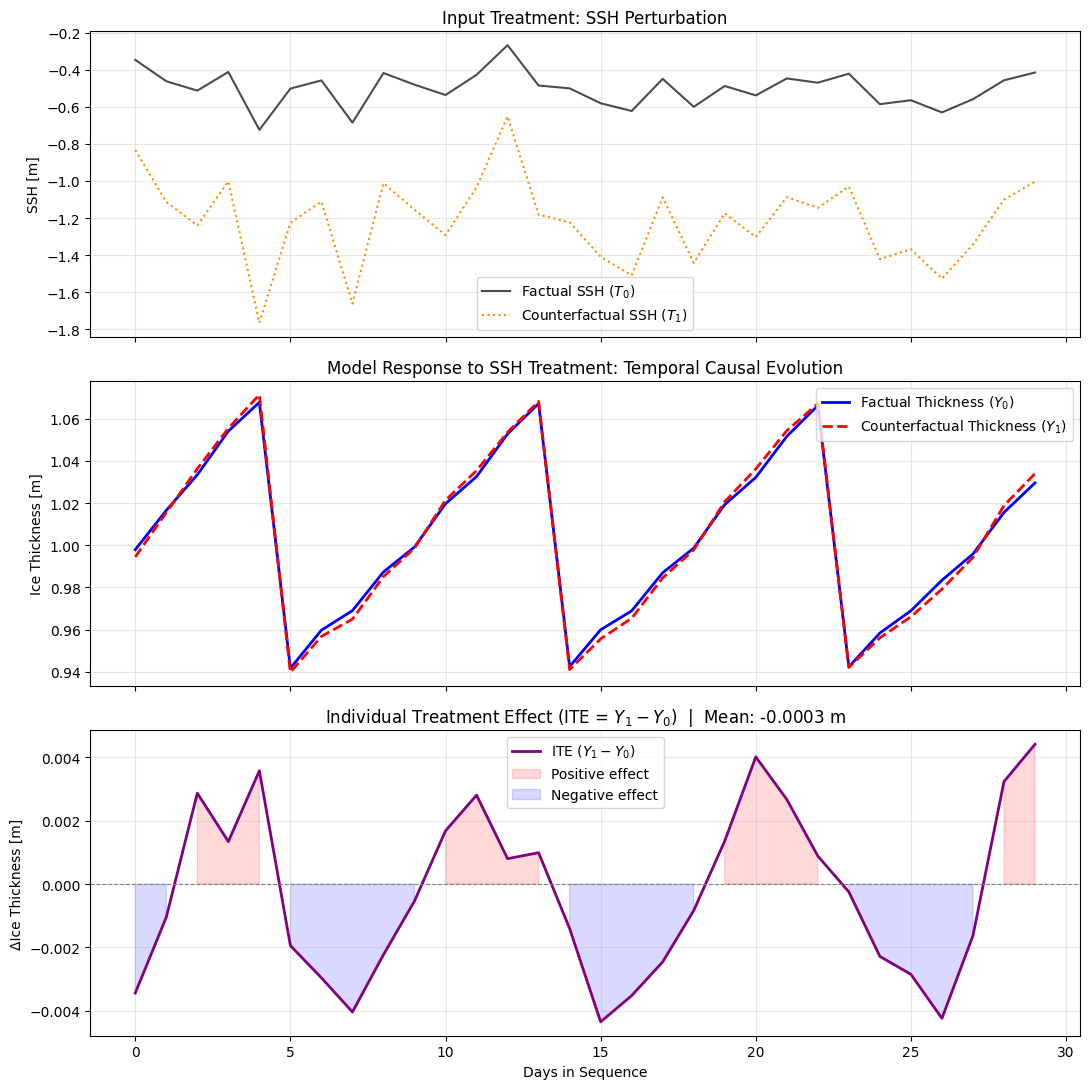

In [11]:
import os
import math
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -----------------------------
# REPRODUCIBILITY & CONFIG
# -----------------------------
REPRODUCIBILITY_SEED = 42
random.seed(REPRODUCIBILITY_SEED)
np.random.seed(REPRODUCIBILITY_SEED)
torch.manual_seed(REPRODUCIBILITY_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dim_y_features = 1
SEQUENCE_LENGTH = 30
BATCH_SIZE      = 64
WINDOW_SIZE     = 5
CSV_FILE_PATH = "arctic_s2s_multivar_2020_2024.csv"

# -----------------------------
# 1. DATA LOADER
# -----------------------------
class ArcticDataLoader:
    def __init__(self, csv_path, batch_size, sequence_length, treatment_lag=1):
        self.csv_path        = csv_path
        self.batch_size      = batch_size
        self.sequence_length = sequence_length
        self.treatment_lag   = treatment_lag
        self._load_and_preprocess_data()

    @staticmethod
    def apply_moving_window(series, window_size):
        return pd.Series(series.flatten()).rolling(
            window=window_size, min_periods=1
        ).mean().values.reshape(-1, 1)

    def _compute_lag(self, T, lag):
        Tlag = np.zeros_like(T)
        for i in range(lag, len(T)):
            Tlag[i, 0] = T[i - lag, 0]
        return Tlag

    def _load_and_preprocess_data(self):
        df = pd.read_csv(self.csv_path)

        xall_np = df[['uoe', 'von', 'total_vel', 'zos']].values
        yall_np = df[['sithick']].values
        ssh     = df['zos'].values.reshape(-1, 1)
        vel     = df['total_vel'].values.reshape(-1, 1)

        # Control treatment T0: smoothed SSH + noise (no hidden)
        T0_smooth = self.apply_moving_window(ssh, WINDOW_SIZE)
        np.random.seed(REPRODUCIBILITY_SEED)
        T0_np     = T0_smooth + np.random.normal(0, 0.1, ssh.shape)

        # Treated treatment T1: regime-dependent scaling using raw velocity
        v0      = np.mean(vel)
        sigmoid = 1 / (1 + np.exp(-(-5.0) * (ssh - v0)))
        T1_np   = ((1.0 + 1.5 * sigmoid) * T0_np).reshape(-1, 1)

        # Treatment lags
        T0_lag_np = self._compute_lag(T0_np, self.treatment_lag)
        T1_lag_np = self._compute_lag(T1_np, self.treatment_lag)

        X_IN_FACTUAL_np   = np.concatenate([xall_np, T0_np, T0_lag_np], axis=1)
        self.actual_dim_x = X_IN_FACTUAL_np.shape[1]

        N       = X_IN_FACTUAL_np.shape[0] - self.treatment_lag
        num_seq = N // self.sequence_length

        def trim(arr):
            start = self.treatment_lag
            end   = start + (num_seq * self.sequence_length)
            return arr[start:end]

        self.xall   = trim(X_IN_FACTUAL_np).reshape(num_seq, self.sequence_length, self.actual_dim_x)
        self.yall   = trim(yall_np).reshape(num_seq, self.sequence_length, dim_y_features)
        self.T0     = trim(T0_np).reshape(num_seq, self.sequence_length, 1)
        self.T1     = trim(T1_np).reshape(num_seq, self.sequence_length, 1)
        self.T0_lag = trim(T0_lag_np).reshape(num_seq, self.sequence_length, 1)
        self.T1_lag = trim(T1_lag_np).reshape(num_seq, self.sequence_length, 1)

        self.x_scaler = StandardScaler()
        self.x_scaled = self.x_scaler.fit_transform(
            self.xall.reshape(-1, self.actual_dim_x)
        ).reshape(num_seq, self.sequence_length, self.actual_dim_x)
        self.y_scaler = StandardScaler()
        self.y_scaled = self.y_scaler.fit_transform(
            self.yall.reshape(-1, dim_y_features)
        ).reshape(num_seq, self.sequence_length, dim_y_features)
        self.ym, self.ys = float(self.y_scaler.mean_[0]), float(self.y_scaler.scale_[0])

    def get_dataloaders(self):
        indices = np.arange(len(self.x_scaled))
        tr_idx, te_idx = train_test_split(indices, test_size=0.2, random_state=42)

        to_t = lambda a: torch.FloatTensor(a)
        train_loader = DataLoader(TensorDataset(
            to_t(self.x_scaled[tr_idx]),
            to_t(self.T0[tr_idx]),
            to_t(self.y_scaled[tr_idx])
        ), batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(TensorDataset(
            to_t(self.x_scaled[te_idx]),
            to_t(self.T0[te_idx]),
            to_t(self.T1[te_idx]),
            to_t(self.T0_lag[te_idx]),
            to_t(self.T1_lag[te_idx]),
            to_t(self.y_scaled[te_idx])
        ), batch_size=BATCH_SIZE, shuffle=False)
        return train_loader, test_loader

# -----------------------------
# 2. MODEL (DCMVAE)
# -----------------------------
HIDDEN_DIM  = 128
LATENT_DIM  = 64
KL_WEIGHT   = 0.001
MMD_WEIGHT  = 1.0

def gaussian_rbf_matrix(x, y, sigma=1.0):
    x_norm = (x ** 2).sum(1).unsqueeze(1)
    y_norm = (y ** 2).sum(1).unsqueeze(0)
    dists  = x_norm + y_norm - 2 * (x @ y.t())
    return torch.exp(-dists / (2 * sigma**2 + 1e-12))

def compute_mmd_stable(x, y):
    if x is None or y is None or x.size(0) <= 1 or y.size(0) <= 1:
        return torch.tensor(0.0, device=DEVICE)
    mmd = 0.0
    for sigma in [0.5, 1.0, 2.0]:
        K_xx = gaussian_rbf_matrix(x, x, sigma)
        K_yy = gaussian_rbf_matrix(y, y, sigma)
        K_xy = gaussian_rbf_matrix(x, y, sigma)
        n, m = x.size(0), y.size(0)
        sum_xx = (K_xx.sum() - torch.diag(K_xx).sum()) / (n * (n - 1))
        sum_yy = (K_yy.sum() - torch.diag(K_yy).sum()) / (m * (m - 1))
        sum_xy = K_xy.mean()
        mmd += sum_xx + sum_yy - 2.0 * sum_xy
    return mmd / 3.0

class DCMVAE(nn.Module):
    def __init__(self, dim_x):
        super().__init__()
        self.encoder_rnn = nn.GRU(
            dim_x + 1, HIDDEN_DIM,
            batch_first=True, bidirectional=True
        )
        self.fc_mu     = nn.Linear(HIDDEN_DIM * 2, LATENT_DIM)
        self.fc_logvar = nn.Linear(HIDDEN_DIM * 2, LATENT_DIM)
        self.t_proj = nn.Sequential(nn.Linear(1, 16), nn.ReLU())
        self.outcome_head = nn.Sequential(
            nn.Linear(LATENT_DIM + 16, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X, t, mode='train'):
        x_and_t = torch.cat([X, t], dim=-1)
        h, _    = self.encoder_rnn(x_and_t)
        mu      = self.fc_mu(h)
        logvar  = self.fc_logvar(h)
        std     = torch.exp(0.5 * logvar)
        z       = mu + torch.randn_like(mu) * std if mode == 'train' else mu
        t_emb   = self.t_proj(t)
        z_and_t = torch.cat([z, t_emb], dim=-1)
        y_pred  = self.outcome_head(z_and_t)
        return y_pred, mu, logvar, z

# -----------------------------
# 3. TRAINING & EVALUATION
# -----------------------------
def run_study():
    dm = ArcticDataLoader(CSV_FILE_PATH, BATCH_SIZE, SEQUENCE_LENGTH)
    train_loader, test_loader = dm.get_dataloaders()
    t_median = float(np.median(dm.T0))

    model = DCMVAE(dm.actual_dim_x).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

    NUM_EPOCHS = 150
    print(f"Training on {dm.actual_dim_x} input channels...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        kl_scale  = min(1.0, epoch / 30.0)
        mmd_scale = min(1.0, epoch / 50.0)

        for x, t0, y in train_loader:
            x, t0, y = x.to(DEVICE), t0.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()

            y_pred, mu, logvar, z = model(x, t0, mode='train')
            loss_recon = F.mse_loss(y_pred, y)
            loss_kl    = torch.clamp(
                -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()), max=1.0
            )
            z_flat = z.view(-1, LATENT_DIM)
            t_flat = (t0.view(-1) > t_median).float()
            z0_mmd = z_flat[t_flat == 0]
            z1_mmd = z_flat[t_flat == 1]
            loss_mmd = compute_mmd_stable(z0_mmd, z1_mmd) * mmd_scale

            loss = 10.0 * loss_recon + KL_WEIGHT * kl_scale * loss_kl + MMD_WEIGHT * loss_mmd
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            epoch_loss += loss.item()

        scheduler.step(epoch_loss / len(train_loader))
        if (epoch + 1) % 30 == 0 or epoch == NUM_EPOCHS - 1:
            print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss/len(train_loader):.4f}")

    # --- INFERENCE & PLOTTING ---
    model.eval()
    with torch.no_grad():
        x, t0, t1, t0l, t1l, y = next(iter(test_loader))
        x, t0, t1 = x.to(DEVICE), t0.to(DEVICE), t1.to(DEVICE)

        y0_pred, _, _, _ = model(x, t0, mode='eval')
        y1_pred, _, _, _ = model(x, t1, mode='eval')

        y0_hat_scaled = y0_pred.squeeze(-1).cpu().numpy()
        y1_hat_scaled = y1_pred.squeeze(-1).cpu().numpy()

        y0_hat = (y0_hat_scaled * dm.ys) + dm.ym
        y1_hat = (y1_hat_scaled * dm.ys) + dm.ym
        ite    = y1_hat - y0_hat

        t0_plot = t0[0].cpu().numpy()
        t1_plot = t1[0].cpu().numpy()

    # Three panels
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 11), sharex=True)

    ax1.plot(t0_plot, label='Factual SSH ($T_0$)', color='black', alpha=0.7)
    ax1.plot(t1_plot, label='Counterfactual SSH ($T_1$)', color='darkorange', linestyle=':')
    ax1.set_title("Input Treatment: SSH Perturbation")
    ax1.set_ylabel("SSH [m]")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(y0_hat[0], label='Factual Thickness ($Y_0$)', color='blue', linewidth=2)
    ax2.plot(y1_hat[0], label='Counterfactual Thickness ($Y_1$)', color='red', linestyle='--', linewidth=2)
    ax2.set_title("Model Response to SSH Treatment: Temporal Causal Evolution")
    ax2.set_ylabel("Ice Thickness [m]")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ite_sample = ite[0]
    ax3.plot(ite_sample, color='purple', linewidth=2, label='ITE ($Y_1 - Y_0$)')
    ax3.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax3.fill_between(range(len(ite_sample)), ite_sample, 0,
                     where=(ite_sample >= 0), color='red',  alpha=0.15, label='Positive effect')
    ax3.fill_between(range(len(ite_sample)), ite_sample, 0,
                     where=(ite_sample <  0), color='blue', alpha=0.15, label='Negative effect')
    ax3.set_title(f"Individual Treatment Effect (ITE = $Y_1 - Y_0$)  |  Mean: {ite_sample.mean():.4f} m")
    ax3.set_xlabel("Days in Sequence")
    ax3.set_ylabel("ΔIce Thickness [m]")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("sit_ssh.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    run_study()


Training on 6 input channels...
Epoch 030 | Loss: 2.3731
Epoch 060 | Loss: 0.2263
Epoch 090 | Loss: 0.1021
Epoch 120 | Loss: 0.0549
Epoch 150 | Loss: 0.0426


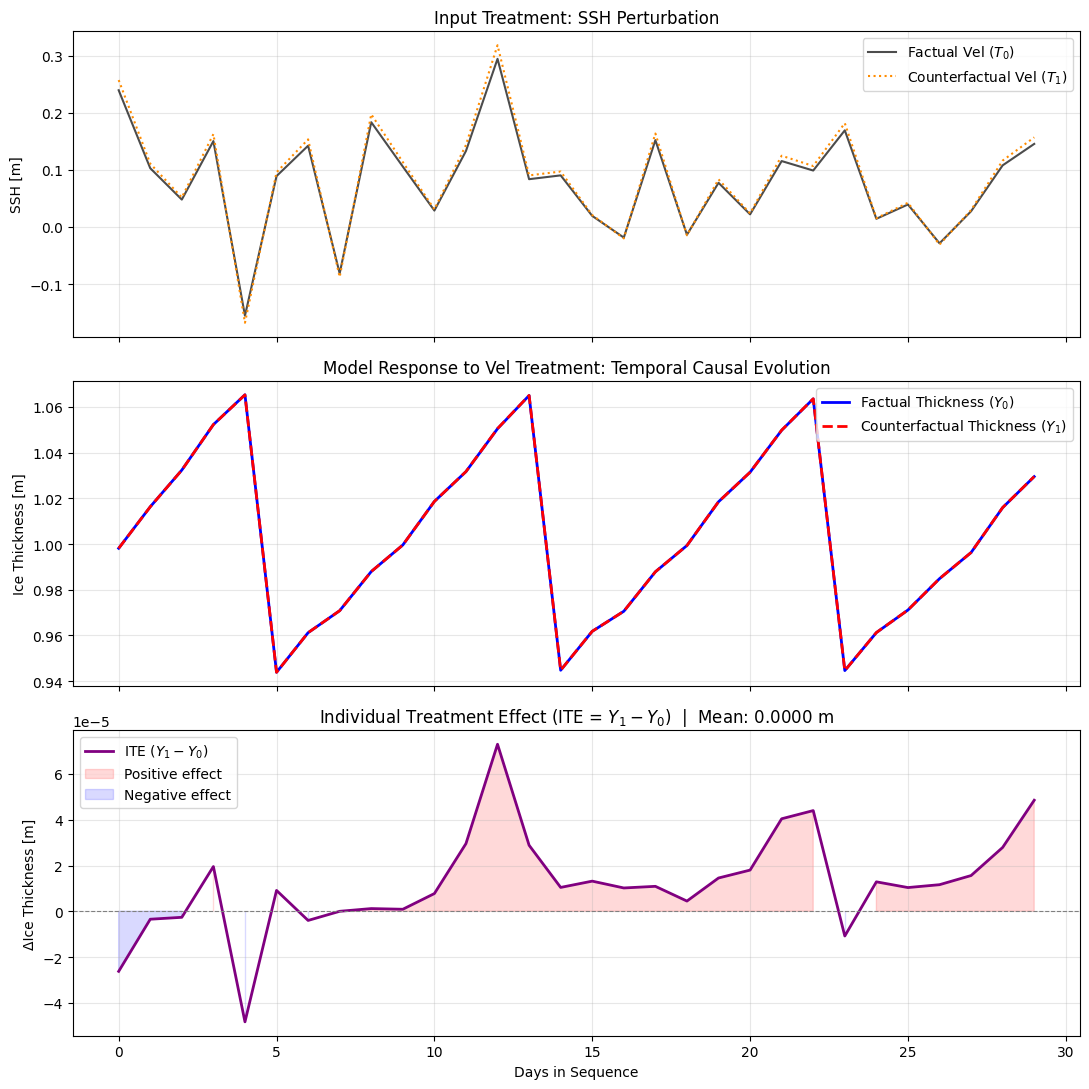

In [13]:
import os
import math
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -----------------------------
# REPRODUCIBILITY & CONFIG
# -----------------------------
REPRODUCIBILITY_SEED = 42
random.seed(REPRODUCIBILITY_SEED)
np.random.seed(REPRODUCIBILITY_SEED)
torch.manual_seed(REPRODUCIBILITY_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dim_y_features = 1
SEQUENCE_LENGTH = 30
BATCH_SIZE      = 64
WINDOW_SIZE     = 5
CSV_FILE_PATH = "/content/drive/MyDrive/Feb25-correction-chapter3codes-2026/arctic_s2s_multivar_2020_2024.csv"

# -----------------------------
# 1. DATA LOADER
# -----------------------------
class ArcticDataLoader:
    def __init__(self, csv_path, batch_size, sequence_length, treatment_lag=1):
        self.csv_path        = csv_path
        self.batch_size      = batch_size
        self.sequence_length = sequence_length
        self.treatment_lag   = treatment_lag
        self._load_and_preprocess_data()

    @staticmethod
    def apply_moving_window(series, window_size):
        return pd.Series(series.flatten()).rolling(
            window=window_size, min_periods=1
        ).mean().values.reshape(-1, 1)

    def _compute_lag(self, T, lag):
        Tlag = np.zeros_like(T)
        for i in range(lag, len(T)):
            Tlag[i, 0] = T[i - lag, 0]
        return Tlag

    def _load_and_preprocess_data(self):
        df = pd.read_csv(self.csv_path)

        xall_np = df[['uoe', 'von', 'total_vel', 'zos']].values
        yall_np = df[['sithick']].values
        ssh     = df['zos'].values.reshape(-1, 1)
        vel     = df['total_vel'].values.reshape(-1, 1)

        # Control treatment T0: smoothed SSH + noise (no hidden)
        T0_smooth = self.apply_moving_window(vel, WINDOW_SIZE)
        np.random.seed(REPRODUCIBILITY_SEED)
        T0_np     = T0_smooth + np.random.normal(0, 0.1, ssh.shape)

        # Treated treatment T1: regime-dependent scaling using raw velocity
        v0      = np.mean(ssh)
        sigmoid = 1 / (1 + np.exp(-(-5.0) * (vel - v0)))
        T1_np   = ((1.0 + 1.5 * sigmoid) * T0_np).reshape(-1, 1)

        # Treatment lags
        T0_lag_np = self._compute_lag(T0_np, self.treatment_lag)
        T1_lag_np = self._compute_lag(T1_np, self.treatment_lag)

        X_IN_FACTUAL_np   = np.concatenate([xall_np, T0_np, T0_lag_np], axis=1)
        self.actual_dim_x = X_IN_FACTUAL_np.shape[1]

        N       = X_IN_FACTUAL_np.shape[0] - self.treatment_lag
        num_seq = N // self.sequence_length

        def trim(arr):
            start = self.treatment_lag
            end   = start + (num_seq * self.sequence_length)
            return arr[start:end]

        self.xall   = trim(X_IN_FACTUAL_np).reshape(num_seq, self.sequence_length, self.actual_dim_x)
        self.yall   = trim(yall_np).reshape(num_seq, self.sequence_length, dim_y_features)
        self.T0     = trim(T0_np).reshape(num_seq, self.sequence_length, 1)
        self.T1     = trim(T1_np).reshape(num_seq, self.sequence_length, 1)
        self.T0_lag = trim(T0_lag_np).reshape(num_seq, self.sequence_length, 1)
        self.T1_lag = trim(T1_lag_np).reshape(num_seq, self.sequence_length, 1)

        self.x_scaler = StandardScaler()
        self.x_scaled = self.x_scaler.fit_transform(
            self.xall.reshape(-1, self.actual_dim_x)
        ).reshape(num_seq, self.sequence_length, self.actual_dim_x)
        self.y_scaler = StandardScaler()
        self.y_scaled = self.y_scaler.fit_transform(
            self.yall.reshape(-1, dim_y_features)
        ).reshape(num_seq, self.sequence_length, dim_y_features)
        self.ym, self.ys = float(self.y_scaler.mean_[0]), float(self.y_scaler.scale_[0])

    def get_dataloaders(self):
        indices = np.arange(len(self.x_scaled))
        tr_idx, te_idx = train_test_split(indices, test_size=0.2, random_state=42)

        to_t = lambda a: torch.FloatTensor(a)
        train_loader = DataLoader(TensorDataset(
            to_t(self.x_scaled[tr_idx]),
            to_t(self.T0[tr_idx]),
            to_t(self.y_scaled[tr_idx])
        ), batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(TensorDataset(
            to_t(self.x_scaled[te_idx]),
            to_t(self.T0[te_idx]),
            to_t(self.T1[te_idx]),
            to_t(self.T0_lag[te_idx]),
            to_t(self.T1_lag[te_idx]),
            to_t(self.y_scaled[te_idx])
        ), batch_size=BATCH_SIZE, shuffle=False)
        return train_loader, test_loader

# -----------------------------
# 2. MODEL (DCMVAE)
# -----------------------------
HIDDEN_DIM  = 128
LATENT_DIM  = 64
KL_WEIGHT   = 0.001
MMD_WEIGHT  = 1.0

def gaussian_rbf_matrix(x, y, sigma=1.0):
    x_norm = (x ** 2).sum(1).unsqueeze(1)
    y_norm = (y ** 2).sum(1).unsqueeze(0)
    dists  = x_norm + y_norm - 2 * (x @ y.t())
    return torch.exp(-dists / (2 * sigma**2 + 1e-12))

def compute_mmd_stable(x, y):
    if x is None or y is None or x.size(0) <= 1 or y.size(0) <= 1:
        return torch.tensor(0.0, device=DEVICE)
    mmd = 0.0
    for sigma in [0.5, 1.0, 2.0]:
        K_xx = gaussian_rbf_matrix(x, x, sigma)
        K_yy = gaussian_rbf_matrix(y, y, sigma)
        K_xy = gaussian_rbf_matrix(x, y, sigma)
        n, m = x.size(0), y.size(0)
        sum_xx = (K_xx.sum() - torch.diag(K_xx).sum()) / (n * (n - 1))
        sum_yy = (K_yy.sum() - torch.diag(K_yy).sum()) / (m * (m - 1))
        sum_xy = K_xy.mean()
        mmd += sum_xx + sum_yy - 2.0 * sum_xy
    return mmd / 3.0

class DCMVAE(nn.Module):
    def __init__(self, dim_x):
        super().__init__()
        self.encoder_rnn = nn.GRU(
            dim_x + 1, HIDDEN_DIM,
            batch_first=True, bidirectional=True
        )
        self.fc_mu     = nn.Linear(HIDDEN_DIM * 2, LATENT_DIM)
        self.fc_logvar = nn.Linear(HIDDEN_DIM * 2, LATENT_DIM)
        self.t_proj = nn.Sequential(nn.Linear(1, 16), nn.ReLU())
        self.outcome_head = nn.Sequential(
            nn.Linear(LATENT_DIM + 16, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, X, t, mode='train'):
        x_and_t = torch.cat([X, t], dim=-1)
        h, _    = self.encoder_rnn(x_and_t)
        mu      = self.fc_mu(h)
        logvar  = self.fc_logvar(h)
        std     = torch.exp(0.5 * logvar)
        z       = mu + torch.randn_like(mu) * std if mode == 'train' else mu
        t_emb   = self.t_proj(t)
        z_and_t = torch.cat([z, t_emb], dim=-1)
        y_pred  = self.outcome_head(z_and_t)
        return y_pred, mu, logvar, z

# -----------------------------
# 3. TRAINING & EVALUATION
# -----------------------------
def run_study():
    dm = ArcticDataLoader(CSV_FILE_PATH, BATCH_SIZE, SEQUENCE_LENGTH)
    train_loader, test_loader = dm.get_dataloaders()
    t_median = float(np.median(dm.T0))

    model = DCMVAE(dm.actual_dim_x).to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

    NUM_EPOCHS = 150
    print(f"Training on {dm.actual_dim_x} input channels...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        kl_scale  = min(1.0, epoch / 30.0)
        mmd_scale = min(1.0, epoch / 50.0)

        for x, t0, y in train_loader:
            x, t0, y = x.to(DEVICE), t0.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()

            y_pred, mu, logvar, z = model(x, t0, mode='train')
            loss_recon = F.mse_loss(y_pred, y)
            loss_kl    = torch.clamp(
                -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()), max=1.0
            )
            z_flat = z.view(-1, LATENT_DIM)
            t_flat = (t0.view(-1) > t_median).float()
            z0_mmd = z_flat[t_flat == 0]
            z1_mmd = z_flat[t_flat == 1]
            loss_mmd = compute_mmd_stable(z0_mmd, z1_mmd) * mmd_scale

            loss = 10.0 * loss_recon + KL_WEIGHT * kl_scale * loss_kl + MMD_WEIGHT * loss_mmd
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            epoch_loss += loss.item()

        scheduler.step(epoch_loss / len(train_loader))
        if (epoch + 1) % 30 == 0 or epoch == NUM_EPOCHS - 1:
            print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss/len(train_loader):.4f}")

    # --- INFERENCE & PLOTTING ---
    model.eval()
    with torch.no_grad():
        x, t0, t1, t0l, t1l, y = next(iter(test_loader))
        x, t0, t1 = x.to(DEVICE), t0.to(DEVICE), t1.to(DEVICE)

        y0_pred, _, _, _ = model(x, t0, mode='eval')
        y1_pred, _, _, _ = model(x, t1, mode='eval')

        y0_hat_scaled = y0_pred.squeeze(-1).cpu().numpy()
        y1_hat_scaled = y1_pred.squeeze(-1).cpu().numpy()

        y0_hat = (y0_hat_scaled * dm.ys) + dm.ym
        y1_hat = (y1_hat_scaled * dm.ys) + dm.ym
        ite    = y1_hat - y0_hat

        t0_plot = t0[0].cpu().numpy()
        t1_plot = t1[0].cpu().numpy()

    # Three panels
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(11, 11), sharex=True)

    ax1.plot(t0_plot, label='Factual Vel ($T_0$)', color='black', alpha=0.7)
    ax1.plot(t1_plot, label='Counterfactual Vel ($T_1$)', color='darkorange', linestyle=':')
    ax1.set_title("Input Treatment: SSH Perturbation")
    ax1.set_ylabel("SSH [m]")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(y0_hat[0], label='Factual Thickness ($Y_0$)', color='blue', linewidth=2)
    ax2.plot(y1_hat[0], label='Counterfactual Thickness ($Y_1$)', color='red', linestyle='--', linewidth=2)
    ax2.set_title("Model Response to Vel Treatment: Temporal Causal Evolution")
    ax2.set_ylabel("Ice Thickness [m]")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ite_sample = ite[0]
    ax3.plot(ite_sample, color='purple', linewidth=2, label='ITE ($Y_1 - Y_0$)')
    ax3.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax3.fill_between(range(len(ite_sample)), ite_sample, 0,
                     where=(ite_sample >= 0), color='red',  alpha=0.15, label='Positive effect')
    ax3.fill_between(range(len(ite_sample)), ite_sample, 0,
                     where=(ite_sample <  0), color='blue', alpha=0.15, label='Negative effect')
    ax3.set_title(f"Individual Treatment Effect (ITE = $Y_1 - Y_0$)  |  Mean: {ite_sample.mean():.4f} m")
    ax3.set_xlabel("Days in Sequence")
    ax3.set_ylabel("ΔIce Thickness [m]")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("sit_vel.png", dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    run_study()
